# Modelling

In [1]:
%%time

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import pandas as pd
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import seaborn
import random
random.seed(42)
import xgboost as xgb
print("XGBoost version:", xgb.__version__)
print("XGBoost config:", xgb.get_config())
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import joblib
import gc
import time

save_dir = "/root/autodl-tmp"

XGBoost version: 2.0.3
XGBoost config: {'use_rmm': False, 'verbosity': 1}
CPU times: user 1.59 s, sys: 811 ms, total: 2.4 s
Wall time: 1.77 s


In [2]:
%%time

# Function to convert seconds to a human-readable string
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours}h {minutes}min {seconds}sec"

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 17.4 µs


In [3]:
%%time

# Load the dataset
df_train = pd.read_parquet("data/prep/df_train.parquet")
df_test = pd.read_parquet("data/prep/df_test.parquet")
    
df_train.info()

# Select X (second column to second last column) and y (last column)
X_train = df_train.iloc[:, 1:-1].values
y_train = df_train.iloc[:, -1].values 
X_test = df_test.iloc[:, 1:-1].values
y_test = df_test.iloc[:, -1].values

# Verify the conversion
print("X_train type:", type(X_train))  # Should be <class 'cupy.ndarray'>
print("y_train type:", type(y_train))  # Should be <class 'cupy.ndarray'>
print("X_test type:", type(X_test))    # Should be <class 'cupy.ndarray'>
print("y_test type:", type(y_test))    # Should be <class 'cupy.ndarray'>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982163 entries, 0 to 982162
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         982163 non-null  object 
 1   vendor_id                  982163 non-null  int64  
 2   passenger_count            982163 non-null  float64
 3   store_and_fwd_flag         982163 non-null  int64  
 4   pickup_pca0                982163 non-null  float64
 5   pickup_pca1                982163 non-null  float64
 6   dropoff_pca0               982163 non-null  float64
 7   dropoff_pca1               982163 non-null  float64
 8   euclidean_distance         982163 non-null  float64
 9   pickup_hour_of_day         982163 non-null  float64
 10  day_of_week                982163 non-null  float64
 11  hour_of_week               982163 non-null  float64
 12  month_of_year              982163 non-null  float64
 13  day_of_year                98

In [4]:
%%time

# Initialize XGBRegressor with GPU support
xgb_model = xgb.XGBRegressor(
    n_estimators=5000,             # Number of boosting rounds
    device="cuda",                 # Use GPU for calculation
    objective="reg:squarederror",  # Regression objective (RMSE)
    eval_metric="rmse",            # Evaluation metric (RMSE)
    early_stopping_rounds=50,
    random_state=42,               # Random seed for reproducibility
    subsample=0.9,
    reg_lambda=0.1,
    reg_alpha=0.1,
    min_child_weight=1,
    max_depth=13,
    learning_rate=0.01,
    gamma=0.1,
    colsample_bytree=0.9
)

CPU times: user 27 µs, sys: 16 µs, total: 43 µs
Wall time: 56.5 µs


## K-Fold Cros Vallidation on Train Test

In [5]:
%%time

# 5-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
k = 1
rmse_scores = []
train_times = []

for train_idx, val_idx in kfold.split(X_train):
    print(f"Preprocessing Fold {k}...")
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    start_time = time.time()
    xgb_model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_val_fold, y_val_fold)],
                  verbose=False)
    train_time = time.time() - start_time
    train_times.append(train_time)
    
    y_pred = xgb_model.predict(X_val_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
    rmse_scores.append(rmse)
    
    print(f"Fold{k} RMSE: {rmse}")
    print(f"Fold{k} RMSE: {format_time(train_time)}")
    k += 1

Preprocessing Fold 1...


/root/miniconda3/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [19:44:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Fold1 RMSE: 0.041827462383669904
Fold1 RMSE: 0h 0min 17sec
Preprocessing Fold 2...
Fold2 RMSE: 0.041965828302610024
Fold2 RMSE: 0h 0min 19sec
Preprocessing Fold 3...
Fold3 RMSE: 0.04178867790694835
Fold3 RMSE: 0h 0min 19sec
Preprocessing Fold 4...
Fold4 RMSE: 0.042057614263064126
Fold4 RMSE: 0h 0min 18sec
Preprocessing Fold 5...
Fold5 RMSE: 0.042032039458888
Fold5 RMSE: 0h 0min 18sec
CPU times: user 57 s, sys: 57.1 s, total: 1min 54s
Wall time: 1min 36s


In [6]:
%%time

# Average RMSE and training time
print(f"RMSE: {rmse_scores}")
print(f"Training Time: {train_times}")
avg_rmse = np.mean(rmse_scores)
avg_train_time = np.mean(train_times)
print(f"Average RMSE: {avg_rmse}")
print(f"Average Training Time: {format_time(avg_train_time)}")

RMSE: [0.041827462383669904, 0.041965828302610024, 0.04178867790694835, 0.042057614263064126, 0.042032039458888]
Training Time: ['0h 0min 17sec', '0h 0min 19sec', '0h 0min 19sec', '0h 0min 18sec', '0h 0min 18sec']


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U13'), dtype('<U13')) -> None

## Train & Test

In [7]:
%%time

# Initialize XGBRegressor with GPU support
xgb_model = xgb.XGBRegressor(
    n_estimators=5000,             # Number of boosting rounds
    device="cuda",                 # Use GPU for calculation
    objective="reg:squarederror",  # Regression objective (RMSE)
    eval_metric="rmse",            # Evaluation metric (RMSE)
    early_stopping_rounds=50,
    random_state=42,               # Random seed for reproducibility
    subsample=0.9,
    reg_lambda=0.1,
    reg_alpha=0.1,
    min_child_weight=1,
    max_depth=13,
    learning_rate=0.01,
    gamma=0.1,
    colsample_bytree=0.9
)

# Define the datasets to evaluate each iteration
eval_set = [(X_train, y_train), (X_test, y_test)]

CPU times: user 3.44 ms, sys: 0 ns, total: 3.44 ms
Wall time: 1.79 ms


In [8]:
%%time

xgb_model.fit(X_train, y_train,
              eval_set=eval_set,
              verbose=True)

[0]	validation_0-rmse:0.09064	validation_1-rmse:0.46278
[1]	validation_0-rmse:0.09002	validation_1-rmse:0.46266
[2]	validation_0-rmse:0.08937	validation_1-rmse:0.46253
[3]	validation_0-rmse:0.08873	validation_1-rmse:0.46241
[4]	validation_0-rmse:0.08813	validation_1-rmse:0.46230
[5]	validation_0-rmse:0.08749	validation_1-rmse:0.46218
[6]	validation_0-rmse:0.08687	validation_1-rmse:0.46207
[7]	validation_0-rmse:0.08625	validation_1-rmse:0.46195
[8]	validation_0-rmse:0.08564	validation_1-rmse:0.46183
[9]	validation_0-rmse:0.08504	validation_1-rmse:0.46172
[10]	validation_0-rmse:0.08445	validation_1-rmse:0.46161
[11]	validation_0-rmse:0.08386	validation_1-rmse:0.46150
[12]	validation_0-rmse:0.08328	validation_1-rmse:0.46140
[13]	validation_0-rmse:0.08271	validation_1-rmse:0.46129
[14]	validation_0-rmse:0.08215	validation_1-rmse:0.46119
[15]	validation_0-rmse:0.08159	validation_1-rmse:0.46109
[16]	validation_0-rmse:0.08106	validation_1-rmse:0.46101
[17]	validation_0-rmse:0.08052	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device='cuda', early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [9]:
%%time

# Save the model to a file
model_save_path = "xgb_regressor_model.pkl"
joblib.dump(xgb_model, model_save_path)
print(f"Model saved to {model_save_path}")

NameError: name 'model' is not defined

Test RMSE: 0.455


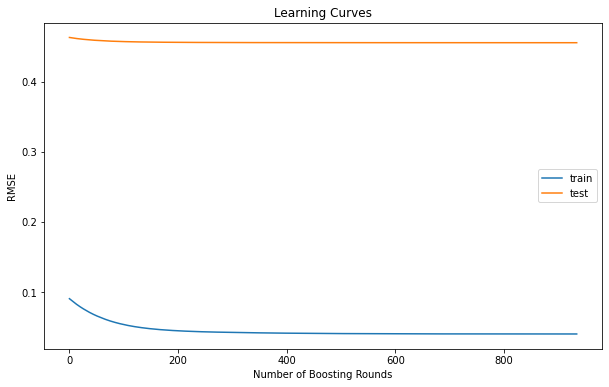

CPU times: user 1.13 s, sys: 377 ms, total: 1.51 s
Wall time: 832 ms


In [10]:
%%time

# Evaluate performance
y_pred = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
print(f"Test RMSE: {rmse:.3f}")

# Retrieve performance metrics
results = xgb_model.evals_result()

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(results["validation_0"]["rmse"], label="train")
plt.plot(results["validation_1"]["rmse"], label="test")
plt.xlabel("Number of Boosting Rounds")
plt.ylabel("RMSE")
plt.title("Learning Curves")
plt.legend()
plt.savefig(os.path.join("images", "xgb-regression-learning-curves.png"),
           dpi=400)
plt.show()